In [1]:
import pyodbc
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import pydot
import graphviz

from tensorflow.keras import layers
import matplotlib.pyplot as plt

from keras.layers import Embedding, Input, dot, Concatenate, Flatten, Dense
# from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.models import Model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
class DBConnector:
    def __init__(self, server_name, username, password, db_name, connection_str):
        self.sever_name = server_name
        self.username = username
        self.password = password
        self.db_name = db_name
        self.connection_str = connection_str
        self.connection = pyodbc.connect(self.connection_str)

    def test_connection(self):
        try:
            db = self.connection
            cursor = db.cursor()
            cursor.execute("SELECT @@VERSION")
            results = cursor.fetchone()
            # Check if anything at all is returned
            if results:
                return True
            else:
                return False
        except pyodbc.Error as ex:
            print(ex)
            print("Error in connection!")
            sqlstate = ex.args[0]
            if sqlstate == '28000':
                print("LDAP Connection failed: check password")
        return False

    def query(self, query_str):
        """This function returns a dataframe of result list"""
        return pd.read_sql_query(query_str, self.connection)

    def all_columns_name(self, table_name):
        """This function returns a dataframe of result list"""
        query_str = f"select COLUMN_NAME from INFORMATION_SCHEMA.COLUMNS where TABLE_NAME='{table_name}'"
        print("All columns names: ", query_str)
        return pd.read_sql_query(query_str, self.connection)

driver="SQL Server"
servername = 'QUOC-CUONG'
username = 'sa'
password = 'cuong300599'
db_name = 'OnlinePhoneShopJoin'

str_for_connection = "Driver={driver};Server={servername};UID={username};PWD={password};Database={db_name};"\
    .format(driver=driver, servername=servername, username=username, password=password, db_name=db_name)

connector = DBConnector(servername, username, password, db_name, str_for_connection)

In [3]:
query_str = "select product_id, product_name, unit_price, label from dbo.products"

label2type={0:"Phụ kiện", 1: "Gaming/ Cấu hình cao", 2:"Giải trí thông thường", 3:"Chỉ nghe và gọi"}
df_products = connector.query(query_str)

df_products["dedicated"] = df_products["label"].map(label2type)
df_products.head(20)

,product_id,product_name,unit_price,label,dedicated
0,PD041020210001,Điện Thoại Samsung Galaxy A12 (4GB/128GB) - ĐÃ...,3.990000e+06,2,Giải trí thông thường
1,PD041020210002,Tai nghe Bluetooth AirPods Pro Wireless Charge...,6.790000e+06,0,Phụ kiện
2,PD041020210003,Điện Thoại Vsmart Joy 4 - Hàng Chính Hãng,3.059000e+06,2,Giải trí thông thường
3,PD041020210004,Tai nghe Bluetooth True Wireless Galaxy Buds P...,3.992000e+06,0,Phụ kiện
4,PD041020210005,Vivo y12,1.000000e+07,2,Giải trí thông thường
5,PD081020210006,Móc dán điện thoại OSMIA RingCK039 Cún Trắng,4.999999e+04,0,Phụ kiện
6,PD081020210007,Máy Tính Bảng HUAWEI MatePad T 10 | Hiệu Suất ...,3.790000e+06,1,Gaming/ Cấu hình cao
7,PD151020210001,Điện Thoại iPhone 12 Pro Max 256GB - Hàng Chín...,3.099000e+07,1,Gaming/ Cấu hình cao
8,PD161020210001,Điện Thoại Oppo A54 - Hàng Chính Hãng,4.290000e+06,2,Giải trí thông thường
9,PD161020210008,Tai Nghe Nhét Tai JBL C150SI - Hàng Chính Hãng,2.030000e+05,0,Phụ kiện


In [4]:
query_str = "select user_id, product_id, score from dbo.ratings"
df_ratings = connector.query(query_str)

# Save to csv file
# df_users_products_ratings_pivotted.to_csv(r'D:\PhoneShopML\data\rating_matrix.csv', header=True, index=True, encoding='utf-8-sig')

print("Number of ratings: ", df_ratings.shape[0])
df_ratings.head(20)

Number of ratings:  310


,user_id,product_id,score
0,US041020210001,PD041020210001,4.0
1,US071020210001,PD041020210001,2.5
2,US281020210001,PD041020210001,1.0
3,US281020210042,PD041020210001,1.5
4,US281020210048,PD041020210001,1.5
5,US281020210053,PD041020210001,2.0
6,US281020210069,PD041020210001,5.0
7,US281020210070,PD041020210001,5.0
8,US041020210001,PD041020210002,2.5
9,US191020210007,PD041020210002,2.5


In [5]:
user_ids = df_ratings['user_id'].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
# print("User to user encode: \n", user2user_encoded)
# print("User encode to user: \n", userencoded2user)

product_ids = df_ratings["product_id"].unique().tolist()
# print("Unique products have been rated: ", len(product_ids))
product2product_encoded = {x: i for i, x in enumerate(product_ids)}
product_encoded2product = {i: x for i, x in enumerate(product_ids)}
# print("Product to product encode: \n", product2product_encoded)
# print("Product encode to product: \n", product_encoded2product)

df_ratings["user"] = df_ratings["user_id"].map(user2user_encoded)
df_ratings["product"] = df_ratings["product_id"].map(product2product_encoded)
df_ratings.head(20)

,user_id,product_id,score,user,product
0,US041020210001,PD041020210001,4.0,0,0
1,US071020210001,PD041020210001,2.5,1,0
2,US281020210001,PD041020210001,1.0,2,0
3,US281020210042,PD041020210001,1.5,3,0
4,US281020210048,PD041020210001,1.5,4,0
5,US281020210053,PD041020210001,2.0,5,0
6,US281020210069,PD041020210001,5.0,6,0
7,US281020210070,PD041020210001,5.0,7,0
8,US041020210001,PD041020210002,2.5,0,1
9,US191020210007,PD041020210002,2.5,8,1


In [6]:
num_users = len(user2user_encoded)
num_products = len(product_encoded2product)

# min and max ratings will be used to normalize the ratings later
min_rating = min(df_ratings['score'])
max_rating = max(df_ratings['score'])

print(f"Number of users having rating: {num_users}, Number of rated products: {num_products}, Min rating: {min_rating}, Max rating: {max_rating}")

Number of users having rating: 67, Number of rated products: 59, Min rating: 1.0, Max rating: 5.0


# Prepare training and validation data

In [7]:
# X = df_ratings[["user", "product"]]
# Y = df_ratings['score']
dataset = df_ratings[['user', 'product', 'score']]
train, test = train_test_split(dataset, test_size=0.2, random_state=42)
dataset.head()

,user,product,score
0,0,0,4.0
1,1,0,2.5
2,2,0,1.0
3,3,0,1.5
4,4,0,1.5


In [8]:
train.head()

,user,product,score
126,34,12,3.5
109,49,9,3.5
247,60,48,2.0
234,3,45,1.0
202,26,37,5.0


In [9]:
test.head()

,user,product,score
289,11,54,3.5
9,8,1,2.5
57,33,4,4.5
60,39,5,2.5
25,21,2,3.0


# Build model

In [10]:
n_latent_factors = 50

# # User Embeddings
# user_input = Input(shape=(1,), name='User_Input')
# user_embeddings = Embedding(input_dim = num_users, output_dim=n_latent_factors, input_length=1, 
#                               name='User_Embedding') (user_input)
# user_vector = Flatten(name='User_Vector') (user_embeddings)


# # Product Embeddings
# product_input = Input(shape=(1,), name='Product_Input')
# product_embeddings = Embedding(input_dim = num_products, output_dim=n_latent_factors, input_length=1, 
#                                name='Product_Embedding') (product_input)
# product_vector = Flatten(name='Product_Vector') (product_embeddings)


# # Concatenate Product
# merged_vectors = concatenate([user_vector, product_vector], name='Concantenate')
# dense_layer_1 = Dense(100, activation='relu')(merged_vectors) 
# # dense_layer_1 = Dropout(0.25) (dense_layer_1)
# # batchnorm_layer_1 = BatchNormalization()(dense_layer_1)
# # dense_layer_2 = Dense(64, activation='relu')(merged_vectors)


# result = Dense(1)(dense_layer_1)
# model = Model([user_input, product_input], result)

# model.compile(
#     loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=0.0001)
# )
# Visualize model
# SVG(model_to_dot( model,  show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [11]:
product_input = Input(shape=[1], name="Product-Input")
product_embedding = Embedding(num_products+1, n_latent_factors, name="Product-Embedding")(product_input)
product_vec = Flatten(name="Flatten-Products")(product_embedding)

# creating user embedding path
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(num_users+1, n_latent_factors, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

# concatenate features
conc = Concatenate()([product_vec, user_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model = Model([user_input, product_input], out)
model.compile('adam', 'mean_squared_error')

# Train the model based on the data split

In [12]:
# history = model.fit(
#     x=x_train,
#     y=y_train,
#     batch_size=64,
#     epochs=20,
#     verbose=1,
#     validation_data=(x_val, y_val),
# )

batch_size = 64
epochs = 20

# history = model.fit(
#     [train.user, train.product], 
#     train.score, 
#     epochs=5, 
#     verbose=1)
# model.save('regression_model.h5')
history = model.fit(x=[train['user'], train['product']], y=train.score, batch_size= batch_size, epochs=epochs, 
                    verbose= 1, validation_data=([test['user'], test['product']], test.score))

Epoch 1/20
4/4 [==============================] - 1s 108ms/step - loss: 10.2365 - val_loss: 10.0987
Epoch 2/20
4/4 [==============================] - 0s 54ms/step - loss: 9.8231 - val_loss: 9.7172
Epoch 3/20
4/4 [==============================] - 0s 63ms/step - loss: 9.4161 - val_loss: 9.2638
Epoch 4/20
4/4 [==============================] - 0s 65ms/step - loss: 8.9073 - val_loss: 8.7016
Epoch 5/20
4/4 [==============================] - 0s 43ms/step - loss: 8.2508 - val_loss: 7.9872
Epoch 6/20
4/4 [==============================] - 0s 10ms/step - loss: 7.4055 - val_loss: 7.0707
Epoch 7/20
4/4 [==============================] - 0s 12ms/step - loss: 6.3211 - val_loss: 5.9203
Epoch 8/20
4/4 [==============================] - 0s 11ms/step - loss: 5.0429 - val_loss: 4.5676
Epoch 9/20
4/4 [==============================] - 0s 11ms/step - loss: 3.5595 - val_loss: 3.1845
Epoch 10/20
4/4 [==============================] - 0s 11ms/step - loss: 2.2523 - val_loss: 2.0812
Epoch 11/20
4/4 [=========

# Plot history and validation loss

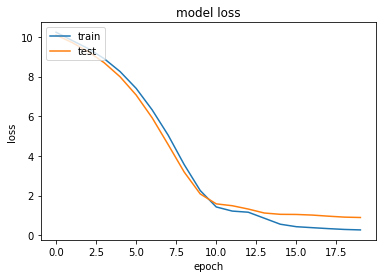

In [13]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Model Summary

In [14]:
model.summary()
tf.keras.utils.plot_model(model, to_file='CF_DeepLearning_Model.png', show_shapes=True, show_layer_names=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Product-Input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 User-Input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Product-Embedding (Embedding)  (None, 1, 50)        3000        ['Product-Input[0][0]']          
                                                                                                  
 User-Embedding (Embedding)     (None, 1, 50)        3400        ['User-Input[0][0]']             
                                                                                              

In [15]:
model.evaluate([test['user'], test['product']], test.score)

2/2 [==============================] - 0s 3ms/step - loss: 0.8909


0.8908892273902893

In [16]:
predictions = model.predict([test['user'], test['product']])
print("Prediction on test set:\n")
for index in range(test.shape[0]):
    print(f"Prediction: {predictions[index][0]} - Actual: {test.score.iloc[index]}")

Prediction on test set:

Prediction: 2.445509672164917 - Actual: 3.5
Prediction: 3.5805230140686035 - Actual: 2.5
Prediction: 4.745677471160889 - Actual: 4.5
Prediction: 3.444497585296631 - Actual: 2.5
Prediction: 3.314523458480835 - Actual: 3.0
Prediction: 3.426327705383301 - Actual: 2.5
Prediction: 1.8175357580184937 - Actual: 1.0
Prediction: 4.377674579620361 - Actual: 4.5
Prediction: 3.2872700691223145 - Actual: 3.0
Prediction: 4.415748596191406 - Actual: 4.5
Prediction: 1.086310863494873 - Actual: 1.5
Prediction: 0.7174361348152161 - Actual: 1.5
Prediction: 2.5966336727142334 - Actual: 3.0
Prediction: 3.195488691329956 - Actual: 2.0
Prediction: 2.960343599319458 - Actual: 1.5
Prediction: 1.1165785789489746 - Actual: 1.5
Prediction: 2.3218743801116943 - Actual: 2.0
Prediction: 4.64877986907959 - Actual: 4.0
Prediction: 3.2991957664489746 - Actual: 4.5
Prediction: 3.031489133834839 - Actual: 3.0
Prediction: 3.393862247467041 - Actual: 3.5
Prediction: 3.269033670425415 - Actual: 5.0


# Show top 10 product recommendations to a user

In [17]:
# user_id = df_ratings.user_id.sample(1).iloc[0]
user_id  = 'US281020210063'
print("Showing recommendations for user: {}".format(user_id))
products_rated_by_user = df_ratings[df_ratings.user_id == user_id]
products_not_rated = df_products[
    ~df_products["product_id"].isin(products_rated_by_user.product_id.values)]["product_id"]

products_not_rated = list(set(products_not_rated).intersection(set(product2product_encoded.keys())))
products_not_rated = [[product2product_encoded.get(x)] for x in products_not_rated]

user_encoder = user2user_encoded.get(user_id)

data_to_predict=[]
input_cols = ['user', 'product']
for i in range(len(products_not_rated)):
    data_to_predict.append([user_encoder, products_not_rated[i][0]])
df_data_to_predict = pd.DataFrame(data_to_predict, columns=input_cols)
df_data_to_predict.head()

ratings = model.predict([df_data_to_predict['user'], df_data_to_predict['product']])
top_ratings_indices = ratings.argsort()[-10:][::-1]
# print("Top rating indices: \n", top_ratings_indices)
recommended_product_ids = [
    product_encoded2product.get(products_not_rated[x][0]) for x in top_ratings_indices.flatten()
]

print("Top user's ratings from the past:\n")
top_products_user = (
    products_rated_by_user.sort_values(by="score", ascending=False)
    .head(5)
    .product_id.values
)

cols = ['product_id', 'product_name', 'unit_price', 'dedicated']
history_rated_products = []
df_product_rows = df_products[df_products["product_id"].isin(top_products_user)]
for row in df_product_rows.itertuples():
    history_rated_products.append([row.product_id, row.product_name, row.unit_price,  row.dedicated])
    
df_history_rated_products = pd.DataFrame(history_rated_products, columns=cols)
df_history_rated_products.head()

Showing recommendations for user: US281020210063
Top user's ratings from the past:



,product_id,product_name,unit_price,dedicated
0,PD041020210002,Tai nghe Bluetooth AirPods Pro Wireless Charge...,6790000.0,Phụ kiện
1,PD041020210003,Điện Thoại Vsmart Joy 4 - Hàng Chính Hãng,3059000.0,Giải trí thông thường
2,PD041020210004,Tai nghe Bluetooth True Wireless Galaxy Buds P...,3992000.0,Phụ kiện
3,PD081020210007,Máy Tính Bảng HUAWEI MatePad T 10 | Hiệu Suất ...,3790000.0,Gaming/ Cấu hình cao
4,PD271020210046,Điện thoại Nokia 150 (2020),680000.0,Chỉ nghe và gọi


In [18]:
print("Top 10 product recommendations:\n")

recommended_products = df_products[df_products["product_id"].isin(recommended_product_ids)]
recommended_product_list = []
for row in recommended_products.itertuples():
     recommended_product_list.append([row.product_id, row.product_name, row.unit_price,  row.dedicated])
df_recommend_products = pd.DataFrame(recommended_product_list, columns=cols)
df_recommend_products.head(10)

Top 10 product recommendations:



,product_id,product_name,unit_price,dedicated
0,PD271020210031,Điện thoại Vivo V20 (2021),7790000.0,Gaming/ Cấu hình cao
